## 时序数据

### 一、时序中的基本对象
时间序列的概念在日常生活中十分常见，但对于一个具体的时序事件而言，可以从多个时间对象的角度来描述。例如2020年9月7日周一早上8点整需要到教室上课，这个课会在当天早上10点结束，其中包含了哪些时间概念？

第一，会出现时间戳`（Date times）`的概念，即`'2020-9-7 08:00:00'`和`'2020-9-7 10:00:00'`这两个时间点分别代表了上课和下课的时刻，在`pandas`中称为`Timestamp`。同时，一系列的时间戳可以组成`DatetimeIndex`，而将它放到`Series`中后，`Series`的类型就变为了`datetime64[ns]`，如果有涉及时区则为`datetime64[ns, tz]`，其中`tz`是`timezone`的简写。

第二，会出现时间差`（Time deltas）`的概念，即上课需要的时间，两个`Timestamp`做差就得到了时间差，`pandas`中利用`Timedelta`来表示。类似的，一系列的时间差就组成了`TimedeltaIndex`， 而将它放到`Series`中后，`Series`的类型就变为了`timedelta64[ns]`。

第三，会出现时间段`（Time spans）`的概念，即在8点到10点这个区间都会持续地在上课，在`pandas`利用`Period`来表示。类似的，一系列的时间段就组成了`PeriodIndex`， 而将它放到`Series`中后，`Series`的类型就变为了`Period`。

第四，会出现日期偏置`（Date offsets）`的概念，假设你只知道9月的第一个周一早上8点要去上课，但不知道具体的日期，那么就需要一个类型来处理此类需求。再例如，想要知道2020年9月7日后的第30个工作日是哪一天，那么时间差就解决不了你的问题，从而`pandas`中的`DateOffset`就出现了。同时，`pandas`中没有为一列时间偏置专门设计存储类型，理由也很简单，因为需求比较奇怪，一般来说我们只需要对一批时间特征做一个统一的特殊日期偏置。

### 二、时间戳
#### 1. `Timestamp`的构造与属性  

单个时间戳的生成利用`pd.Timestamp`实现，一般而言的常见日期格式都能被成功转换：



In [81]:
import pandas as pd
import numpy as np

In [82]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
ts = pd.Timestamp('2020/1/1')
ts

Timestamp('2020-01-01 00:00:00')

In [ ]:
ts = pd.Timestamp('2020-1-1 08:10:30')
ts

Timestamp('2020-01-01 08:10:30')


通过`year, month, day, hour, min, second`可以获取具体的数值：

In [ ]:
ts.year

2020

In [ ]:
ts.month

1

In [ ]:
ts.day

1

In [ ]:
ts.hour

8

In [ ]:
ts.minute

10

In [ ]:
ts.second

30

在`pandas`中，时间戳的最小精度为纳秒`ns`，由于使用了64位存储，可以表示的时间范围大约可以如下计算：

$$\rm Time\,Range = \frac{2^{64}}{10^9\times 60\times 60\times 24\times 365} \approx 585 (Years)$$

通过`pd.Timestamp.max`和`pd.Timestamp.min`可以获取时间戳表示的范围，可以看到确实表示的区间年数大小正如上述计算结果：

In [ ]:
pd.Timestamp.max

Timestamp('2262-04-11 23:47:16.854775807')

In [ ]:
pd.Timestamp.min

Timestamp('1677-09-21 00:12:43.145225')

In [ ]:

pd.Timestamp.max.year - pd.Timestamp.min.year

585

#### 2. `Datetime`序列的生成
一组时间戳可以组成时间序列，可以用`to_datetime`和`date_range`来生成。其中，`to_datetime`能够把一列时间戳格式的对象转换成为`datetime64[ns]`类型的时间序列：

In [ ]:
pd.to_datetime(['2020-1-1', '2020-1-3', '2020-1-6'])
df = pd.read_csv('data/learn_pandas.csv')
s = pd.to_datetime(df.Test_Date)
s.head()

0   2019-10-05
1   2019-09-04
2   2019-09-12
3   2020-01-03
4   2019-11-06
Name: Test_Date, dtype: datetime64[ns]


在极少数情况，时间戳的格式不满足转换时，可以强制使用format进行匹配：

In [ ]:
temp = pd.to_datetime(['2020\\1\\1','2020\\1\\3'],format='%Y\\%m\\%d')
temp

DatetimeIndex(['2020-01-01', '2020-01-03'], dtype='datetime64[ns]', freq=None)

> 注意上面由于传入的是列表，而非`pandas`内部的`Series`，因此返回的是`DatetimeIndex`，如果想要转为`datetime64[ns]`的序列，需要显式用`Series`转化：

In [ ]:
pd.Series(temp).head()

0   2020-01-01
1   2020-01-03
dtype: datetime64[ns]

另外，还存在一种把表的多列时间属性拼接转为时间序列的`to_datetime`操作，此时的列名必须和以下给定的时间关键词列名一致：

In [ ]:
df_date_cols = pd.DataFrame({'year': [2020, 2020],
                             'month': [1, 1],
                             'day': [1, 2],
                             'hour': [10, 20],
                             'minute': [30, 50],
                             'second': [20, 40]})
pd.to_datetime(df_date_cols)



0   2020-01-01 10:30:20
1   2020-01-02 20:50:40
dtype: datetime64[ns]

`date_range`是一种生成连续间隔时间的一种方法，其重要的参数为`start, end, freq, periods`，它们分别表示开始时间，结束时间，时间间隔，时间戳个数。其中，四个中的三个参数决定了，那么剩下的一个就随之确定了。这里要注意，开始或结束日期如果作为端点则它会被包含：

In [ ]:
# 包含
pd.date_range('2020-1-1','2020-1-21', freq='10D') 

DatetimeIndex(['2020-01-01', '2020-01-11', '2020-01-21'], dtype='datetime64[ns]', freq='10D')

In [ ]:
pd.date_range('2020-1-1','2020-2-28', freq='10D')

DatetimeIndex(['2020-01-01', '2020-01-11', '2020-01-21', '2020-01-31',
               '2020-02-10', '2020-02-20'],
              dtype='datetime64[ns]', freq='10D')

In [ ]:
# 由于结束日期无法取到，freq不为10天
pd.date_range('2020-1-1', '2020-2-28', periods=6) 

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-12 14:24:00',
               '2020-01-24 04:48:00', '2020-02-04 19:12:00',
               '2020-02-16 09:36:00', '2020-02-28 00:00:00'],
              dtype='datetime64[ns]', freq=None)

一种改变序列采样频率的方法`asfreq`，它能够根据给定的`freq`对序列进行类似于`reindex`的操作：

In [ ]:
s = pd.Series(np.random.rand(5), index=pd.to_datetime(['2020-1-%d'%i for i in range(1,10,2)]))
s.head()

2020-01-01    0.959502
2020-01-03    0.887300
2020-01-05    0.608163
2020-01-07    0.288888
2020-01-09    0.500194
dtype: float64

In [ ]:
s.asfreq('D').head()

2020-01-01    0.959502
2020-01-02         NaN
2020-01-03    0.887300
2020-01-04         NaN
2020-01-05    0.608163
Freq: D, dtype: float64

In [ ]:
s.asfreq('12H').head()

2020-01-01 00:00:00    0.959502
2020-01-01 12:00:00         NaN
2020-01-02 00:00:00         NaN
2020-01-02 12:00:00         NaN
2020-01-03 00:00:00    0.887300
Freq: 12H, dtype: float64

#### 3. dt对象
如同`category, string`的序列上定义了`cat, str`来完成分类数据和文本数据的操作，在时序类型的序列上定义了`dt`对象来完成许多时间序列的相关操作。这里对于`datetime64[ns]`类型而言，可以大致分为三类操作：取出时间相关的属性、判断时间戳是否满足条件、取整操作。

第一类操作的常用属性包括：`date, time, year, month, day, hour, minute, second, microsecond, nanosecond, dayofweek, dayofyear, weekofyear, daysinmonth, quarter`，其中`daysinmonth, quarter`分别表示该月一共有几天和季度。

In [ ]:
s = pd.Series(pd.date_range('2020-1-1','2020-1-3', freq='D'))
s.dt.date

0    2020-01-01
1    2020-01-02
2    2020-01-03
dtype: object

In [ ]:
s.dt.time

0    00:00:00
1    00:00:00
2    00:00:00
dtype: object

In [ ]:
s.dt.day

0    1
1    2
2    3
dtype: int64

In [ ]:
s.dt.daysinmonth

0    31
1    31
2    31
dtype: int64

在这些属性中，经常使用的是`dayofweek`，它返回了周中的星期情况，周一为0、周二为1，以此类推：

In [ ]:
s.dt.dayofweek

0    2
1    3
2    4
dtype: int64

此外，可以通过`month_name, day_name`返回英文的月名和星期名，注意它们是方法而不是属性：

In [ ]:
s.dt.month_name()

0    January
1    January
2    January
dtype: object

In [ ]:
s.dt.day_name()

0    Wednesday
1     Thursday
2       Friday
dtype: object

第二类判断操作主要用于测试是否为月/季/年的第一天或者最后一天：

In [ ]:
# 还可选 is_quarter/month_start
s.dt.is_year_start 

0     True
1    False
2    False
dtype: bool

In [ ]:
# 还可选 is_quarter/month_end
s.dt.is_year_end 

0    False
1    False
2    False
dtype: bool


第三类的取整操作包含`round, ceil, floor`，它们的公共参数为`freq`，常用的包括`H, min, S`（小时、分钟、秒）

In [ ]:
s = pd.Series(pd.date_range('2020-1-1 20:35:00', '2020-1-1 22:35:00', freq='45min'))
s

0   2020-01-01 20:35:00
1   2020-01-01 21:20:00
2   2020-01-01 22:05:00
dtype: datetime64[ns]

In [ ]:
s.dt.round('1H')

0   2020-01-01 21:00:00
1   2020-01-01 21:00:00
2   2020-01-01 22:00:00
dtype: datetime64[ns]

In [ ]:

s.dt.ceil('1H')

0   2020-01-01 21:00:00
1   2020-01-01 22:00:00
2   2020-01-01 23:00:00
dtype: datetime64[ns]

In [ ]:
s.dt.floor('1H')

0   2020-01-01 20:00:00
1   2020-01-01 21:00:00
2   2020-01-01 22:00:00
dtype: datetime64[ns]

#### 4. 时间戳的切片与索引
一般而言，时间戳序列作为索引使用。如果想要选出某个子时间戳序列，第一类方法是利用`dt`对象和布尔条件联合使用，另一种方式是利用切片，后者常用于连续时间戳。

In [ ]:
s = pd.Series(np.random.randint(2,size=366), index=pd.date_range('2020-01-01','2020-12-31'))
idx = pd.Series(s.index).dt
s.head()

2020-01-01    0
2020-01-02    0
2020-01-03    1
2020-01-04    0
2020-01-05    1
Freq: D, dtype: int64

In [ ]:
# Example1：每月的第一天或者最后一天

s[(idx.is_month_start|idx.is_month_end).values].head()

2020-01-01    0
2020-01-31    0
2020-02-01    1
2020-02-29    1
2020-03-01    1
dtype: int64

In [ ]:
# Example2：双休日

s[idx.dayofweek.isin([5,6]).values].head()

2020-01-04    0
2020-01-05    1
2020-01-11    1
2020-01-12    0
2020-01-18    0
dtype: int64

In [ ]:
#Example3：取出单日值

s['2020-01-01']

0

In [ ]:
# Example4：取出七月

s['2020-07'].head()

2020-07-01    1
2020-07-02    1
2020-07-03    1
2020-07-04    1
2020-07-05    0
Freq: D, dtype: int64

In [ ]:

# Example5：取出5月初至7月15日

s['2020-05':'2020-7-15'].head()

2020-05-01    0
2020-05-02    0
2020-05-03    1
2020-05-04    1
2020-05-05    0
Freq: D, dtype: int64

In [ ]:
s['2020-05':'2020-7-15'].tail()

2020-07-11    1
2020-07-12    0
2020-07-13    1
2020-07-14    0
2020-07-15    1
Freq: D, dtype: int64

### 三、时间差
#### 1. Timedelta的生成
正如在第一节中所说，时间差可以理解为两个时间戳的差，这里也可以通过`pd.Timedelta`来构造：

In [ ]:
pd.Timestamp('20200102 08:00:00')-pd.Timestamp('20200101 07:35:00')

Timedelta('1 days 00:25:00')

In [ ]:
# 需要注意加s
pd.Timedelta(days=1, minutes=25) 

Timedelta('1 days 00:25:00')

In [ ]:
# 字符串生成
pd.Timedelta('1 days 25 minutes') 

Timedelta('1 days 00:25:00')

生成时间差序列的主要方式是`pd.to_timedelta`，其类型为`timedelta64[ns]`：

In [ ]:
s = pd.to_timedelta(df.Time_Record)
s.head()

0   0 days 00:04:34
1   0 days 00:04:20
2   0 days 00:05:22
3   0 days 00:04:08
4   0 days 00:05:22
Name: Time_Record, dtype: timedelta64[ns]

与`date_range`一样，时间差序列也可以用`timedelta_range`来生成，它们两者具有一致的参数：

In [ ]:
pd.timedelta_range('0s', '1000s', freq='6min')

TimedeltaIndex(['0 days 00:00:00', '0 days 00:06:00', '0 days 00:12:00'], dtype='timedelta64[ns]', freq='6T')

In [ ]:
pd.timedelta_range('0s', '1000s', periods=3)

TimedeltaIndex(['0 days 00:00:00', '0 days 00:08:20', '0 days 00:16:40'], dtype='timedelta64[ns]', freq=None)

对于`Timedelta`序列，同样也定义了`dt`对象，上面主要定义了的属性包括`days, seconds, mircroseconds, nanoseconds`，它们分别返回了对应的时间差特征。需要注意的是，这里的`seconds`不是指单纯的秒，而是对天数取余后剩余的秒数：

In [ ]:
s.dt.seconds.head()

0    274
1    260
2    322
3    248
4    322
Name: Time_Record, dtype: int64


如果不想对天数取余而直接对应秒数，可以使用`total_seconds`

In [ ]:
s.dt.total_seconds().head()

0    274.0
1    260.0
2    322.0
3    248.0
4    322.0
Name: Time_Record, dtype: float64

与时间戳序列类似，取整函数也是可以在dt对象上使用的：

In [ ]:
pd.to_timedelta(df.Time_Record).dt.round('min').head()

0   0 days 00:05:00
1   0 days 00:04:00
2   0 days 00:05:00
3   0 days 00:04:00
4   0 days 00:05:00
Name: Time_Record, dtype: timedelta64[ns]


#### 2. `Timedelta`的运算
时间差支持的常用运算有三类：与标量的乘法运算、与时间戳的加减法运算、与时间差的加减法与除法运算：

In [ ]:

td1 = pd.Timedelta(days=1)
td2 = pd.Timedelta(days=3)
ts = pd.Timestamp('20200101')
td1 * 2

Timedelta('2 days 00:00:00')

In [ ]:
td2 - td1

Timedelta('2 days 00:00:00')

In [ ]:
ts + td1

Timestamp('2020-01-02 00:00:00')

In [ ]:
ts - td1

Timestamp('2019-12-31 00:00:00')

这些运算都可以移植到时间差的序列上：

In [ ]:
td1 = pd.timedelta_range(start='1 days', periods=5)
td2 = pd.timedelta_range(start='12 hours', freq='2H', periods=5)
ts = pd.date_range('20200101', '20200105')
td1 * 5

TimedeltaIndex(['5 days', '10 days', '15 days', '20 days', '25 days'], dtype='timedelta64[ns]', freq='5D')

In [ ]:
# 逐个相乘
td1 * pd.Series(list(range(5))) 

0    0 days
1    2 days
2    6 days
3   12 days
4   20 days
dtype: timedelta64[ns]

In [ ]:
td1 - td2

TimedeltaIndex(['0 days 12:00:00', '1 days 10:00:00', '2 days 08:00:00',
                '3 days 06:00:00', '4 days 04:00:00'],
               dtype='timedelta64[ns]', freq=None)

In [ ]:
td1 + pd.Timestamp('20200101')

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
# 逐个相加
td1 + ts 

DatetimeIndex(['2020-01-02', '2020-01-04', '2020-01-06', '2020-01-08',
               '2020-01-10'],
              dtype='datetime64[ns]', freq=None)

### 四、日期偏置
#### 1. `Offset`对象
日期偏置是一种和日历相关的特殊时间差，例如回到第一节中的两个问题：如何求2020年9月第一个周一的日期，以及如何求2020年9月7日后的第30个工作日是哪一天。

In [ ]:
pd.Timestamp('20200831') + pd.offsets.WeekOfMonth(week=0,weekday=0)

Timestamp('2020-09-07 00:00:00')

In [ ]:
pd.Timestamp('20200907') + pd.offsets.BDay(30)

Timestamp('2020-10-19 00:00:00')

`Offset`对象在`pd.offsets`中被定义。当使用+时获取离其最近的下一个日期，当使用-时获取离其最近的上一个日期：

In [ ]:

pd.Timestamp('20200831') - pd.offsets.WeekOfMonth(week=0,weekday=0)

Timestamp('2020-08-03 00:00:00')

In [ ]:

pd.Timestamp('20200907') - pd.offsets.BDay(30)

Timestamp('2020-07-27 00:00:00')

In [ ]:
pd.Timestamp('20200907') + pd.offsets.MonthEnd()

Timestamp('2020-09-30 00:00:00')

一个特殊的`Offset`对象`CDay`，其中的`holidays, weekmask`参数能够分别对自定义的日期和星期进行过滤，前者传入了需要过滤的日期列表，后者传入的是三个字母的星期缩写构成的星期字符串，其作用是只保留字符串中出现的星期：

In [ ]:
my_filter = pd.offsets.CDay(n=1,weekmask='Wed Fri',holidays=['20200109'])
dr = pd.date_range('20200108', '20200111')
dr.to_series().dt.dayofweek

2020-01-08    2
2020-01-09    3
2020-01-10    4
2020-01-11    5
Freq: D, dtype: int64

In [ ]:
[i + my_filter for i in dr]

[Timestamp('2020-01-10 00:00:00'),
 Timestamp('2020-01-10 00:00:00'),
 Timestamp('2020-01-15 00:00:00'),
 Timestamp('2020-01-15 00:00:00')]

n表示增加一天CDay，dr中的第一天为20200108，但由于下一天20200109被排除了，并且20200110是合法的周五，因此转为20200110，其他后面的日期处理类似。

> 不要使用部分Offset
在当前版本下由于一些 bug ，不要使用 Day 级别以下的 Offset 对象，比如 Hour, Second 等，请使用对应的 Timedelta 对象来代替。

#### 2. 偏置字符串
前面提到了关于`date_range`的`freq`取值可用`Offset`对象，同时在`pandas`中几乎每一个`Offset`对象绑定了日期偏置字符串`（frequencies strings/offset aliases）`，可以指定`Offset`对应的字符串来替代使用。

In [ ]:
# 月初
pd.date_range('20200101','20200331', freq='MS') 


DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq='MS')

In [ ]:

# 月末
pd.date_range('20200101','20200331', freq='M') 

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31'], dtype='datetime64[ns]', freq='M')

In [ ]:

# 工作日
pd.date_range('20200101','20200110', freq='B') 

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10'],
              dtype='datetime64[ns]', freq='B')

In [ ]:
# 周一
pd.date_range('20200101','20200201', freq='W-MON') 

DatetimeIndex(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27'], dtype='datetime64[ns]', freq='W-MON')

In [ ]:
# 每月第一个周一
pd.date_range('20200101','20200201', freq='WOM-1MON') 

DatetimeIndex(['2020-01-06'], dtype='datetime64[ns]', freq='WOM-1MON')

In [ ]:
pd.date_range('20200101','20200331', freq=pd.offsets.MonthBegin())

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01'], dtype='datetime64[ns]', freq='MS')

In [ ]:
pd.date_range('20200101','20200110', freq=pd.offsets.BDay())

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10'],
              dtype='datetime64[ns]', freq='B')

In [ ]:
pd.date_range('20200101','20200201', freq=pd.offsets.CDay(weekmask='Mon'))

DatetimeIndex(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27'], dtype='datetime64[ns]', freq='C')

In [80]:
pd.date_range('20200101','20200201', freq=pd.offsets.WeekOfMonth(week=0,weekday=0))

DatetimeIndex(['2020-01-06'], dtype='datetime64[ns]', freq='WOM-1MON')

> 关于时区问题的说明
各类时间对象的开发，除了使用`python`内置的`datetime`模块，`pandas`还利用了`dateutil`模块，很大一部分是为了处理时区问题。总所周知，我国是没有夏令时调整时间一说的，但有些国家会有这种做法，导致了相对而言一天里可能会有`23/24/25`个小时，也就是`relativedelta`，这使得`Offset`对象和`Timedelta`对象有了对同一问题处理产生不同结果的现象，其中的规则也较为复杂，官方文档的写法存在部分描述错误，并且难以对描述做出统一修正，因为牵涉到了`Offset`相关的很多组件。


### 五、时序中的滑窗与分组
#### 1. 滑动窗口
所谓时序的滑窗函数，即把滑动窗口用`freq`关键词代替，下面给出一个具体的应用案例：在股票市场中有一个指标为`BOLL`指标，它由中轨线、上轨线、下轨线这三根线构成，具体的计算方法分别是N日均值线、N日均值加两倍N日标准差线、N日均值减两倍N日标准差线。利用`rolling`对象计算N=30的`BOLL`指标可以如下写出：

In [83]:

import matplotlib.pyplot as plt
idx = pd.date_range('20200101', '20201231', freq='B')
np.random.seed(2020)
data = np.random.randint(-1,2,len(idx)).cumsum() # 随机游动构造模拟序列
s = pd.Series(data,index=idx)
s.head()

2020-01-01   -1
2020-01-02   -2
2020-01-03   -1
2020-01-06   -1
2020-01-07   -2
Freq: B, dtype: int64

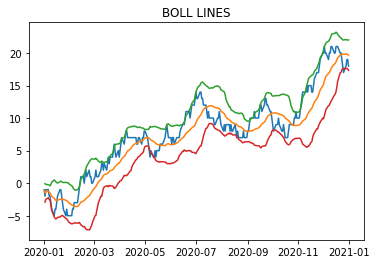

In [84]:
r = s.rolling('30D')
plt.plot(s)
plt.title('BOLL LINES')
plt.plot(r.mean())
plt.plot(r.mean()+r.std()*2)
plt.plot(r.mean()-r.std()*2)


对于`shift`函数而言，作用在`datetime64`为索引的序列上时，可以指定`freq`单位进行滑动：

In [85]:
s.shift(freq='50D').head()

2020-02-20   -1
2020-02-21   -2
2020-02-22   -1
2020-02-25   -1
2020-02-26   -2
dtype: int64


另外，`datetime64[ns]`的序列进行`diff`后就能够得到`timedelta64[ns]`的序列，这能够使用户方便地观察有序时间序列的间隔：

In [86]:
my_series = pd.Series(s.index)
my_series.head()

0   2020-01-01
1   2020-01-02
2   2020-01-03
3   2020-01-06
4   2020-01-07
dtype: datetime64[ns]

In [87]:
my_series.diff(1).head()

0      NaT
1   1 days
2   1 days
3   3 days
4   1 days
dtype: timedelta64[ns]

#### 2. 重采样
重采样对象`resample`和第四章中分组对象`groupby`的用法类似，前者是针对时间序列的分组计算而设计的分组对象。

In [88]:
# 对上面的序列计算每10天的均值：
s.resample('10D').mean().head()

2020-01-01   -2.000000
2020-01-11   -3.166667
2020-01-21   -3.625000
2020-01-31   -4.000000
2020-02-10   -0.375000
Freq: 10D, dtype: float64

In [89]:
# 如果没有内置定义的处理函数，可以通过apply方法自定义：

s.resample('10D').apply(lambda x:x.max()-x.min()).head() # 极差

2020-01-01    3
2020-01-11    4
2020-01-21    4
2020-01-31    2
2020-02-10    4
Freq: 10D, dtype: int64


在`resample`中要特别注意组边界值的处理情况，默认情况下起始值的计算方法是从最小值时间戳对应日期的午夜`00:00:00`开始增加`freq`，直到不超过该最小时间戳的最大时间戳，由此对应的时间戳为起始值，然后每次累加`freq`参数作为分割结点进行分组，区间情况为左闭右开。

In [90]:
idx = pd.date_range('20200101 8:26:35', '20200101 9:31:58', freq='77s')
data = np.random.randint(-1,2,len(idx)).cumsum()
s = pd.Series(data,index=idx)
s.head()

2020-01-01 08:26:35   -1
2020-01-01 08:27:52   -1
2020-01-01 08:29:09   -2
2020-01-01 08:30:26   -3
2020-01-01 08:31:43   -4
Freq: 77S, dtype: int64


下面对应的第一个组起始值为`08:24:00`，其是从当天0点增加72个`freq=7 min`得到的，如果再增加一个`freq`则超出了序列的最小时间戳`08:26:35`：

In [91]:
s.resample('7min').mean().head()

2020-01-01 08:24:00   -1.750000
2020-01-01 08:31:00   -2.600000
2020-01-01 08:38:00   -2.166667
2020-01-01 08:45:00    0.200000
2020-01-01 08:52:00    2.833333
Freq: 7T, dtype: float64

In [92]:
# 可以指定origin参数为start
s.resample('7min', origin='start').mean().head()

2020-01-01 08:26:35   -2.333333
2020-01-01 08:33:35   -2.400000
2020-01-01 08:40:35   -1.333333
2020-01-01 08:47:35    1.200000
2020-01-01 08:54:35    3.166667
Freq: 7T, dtype: float64

在返回值中，要注意索引一般是取组的第一个时间戳，但`M, A, Q, BM, BA, BQ, W`这七个是取对应区间的最后一个时间戳：

In [93]:
s = pd.Series(np.random.randint(2,size=366), index=pd.date_range('2020-01-01', '2020-12-31'))
s.resample('M').mean().head()

2020-01-31    0.451613
2020-02-29    0.448276
2020-03-31    0.516129
2020-04-30    0.566667
2020-05-31    0.451613
Freq: M, dtype: float64

In [94]:
# 结果一样，但索引不同
s.resample('MS').mean().head() 

2020-01-01    0.451613
2020-02-01    0.448276
2020-03-01    0.516129
2020-04-01    0.566667
2020-05-01    0.451613
Freq: MS, dtype: float64

### 六、练习
#### Ex1 ： 太阳辐射数据及
现有一份关于太阳辐射的数据集：
```python

df = pd.read_csv('../data/solar.csv', usecols=['Data','Time','Radiation','Temperature'])
df.head(3)
```


1、 将Datetime, Time合并为一个时间列Datetime，同时把它作为索引后排序。

2、 每条记录时间的间隔显然并不一致，请解决如下问题：
* 找出间隔时间的前三个最大值所对应的三组时间戳。
* 是否存在一个大致的范围，使得绝大多数的间隔时间都落在这个区间中？如果存在，请对此范围内的样本间隔秒数画出柱状图，设置bins=50。

3、 求如下指标对应的Series：
* 温度与辐射量的6小时滑动相关系数
* 以三点、九点、十五点、二十一点为分割，该观测所在时间区间的温度均值序列
* 每个观测6小时前的辐射量（一般而言不会恰好取到，此时取最近时间戳对应的辐射量） 

In [106]:
#1、
df = pd.read_csv('data/solar.csv', usecols=['Data','Time','Radiation','Temperature'])
df.head(3)

,Data,Time,Radiation,Temperature
0,9/29/2016 12:00:00 AM,23:55:26,1.21,48
1,9/29/2016 12:00:00 AM,23:50:23,1.21,48
2,9/29/2016 12:00:00 AM,23:45:26,1.23,48


In [107]:
solar_date = df.Data.str.extract('([/|\w]+\s).+')[0]

In [108]:
df['Data'] = pd.to_datetime(solar_date + df.Time)

In [109]:
df = df.drop(columns='Time').rename(columns={'Data':'Datetime'}
        ).set_index('Datetime').sort_index()

In [110]:
df.head(3)

,Radiation,Temperature
Datetime,,
2016-09-01 00:00:08,2.58,51
2016-09-01 00:05:10,2.83,51
2016-09-01 00:20:06,2.16,51


In [111]:
# 2、
s = df.index.to_series().reset_index(drop=True).diff().dt.total_seconds()
max_3 = s.nlargest(3).index
df.index[max_3.union(max_3-1)]

DatetimeIndex(['2016-09-29 23:55:26', '2016-10-01 00:00:19',
               '2016-11-29 19:05:02', '2016-12-01 00:00:02',
               '2016-12-05 20:45:53', '2016-12-08 11:10:42'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

(array([9.700e+01, 9.200e+01, 1.130e+02, 2.330e+02, 4.080e+02, 2.390e+02,
        1.660e+02, 2.180e+02, 4.140e+02, 5.970e+02, 1.094e+03, 2.112e+03,
        2.675e+03, 4.317e+03, 6.326e+03, 4.262e+03, 2.634e+03, 2.085e+03,
        1.077e+03, 6.330e+02, 4.190e+02, 2.690e+02, 1.570e+02, 2.340e+02,
        3.530e+02, 3.410e+02, 8.600e+01, 4.800e+01, 4.300e+01, 6.200e+01,
        3.500e+01, 4.000e+01, 3.100e+01, 1.800e+01, 1.900e+01, 1.500e+01,
        1.300e+01, 9.000e+00, 1.200e+01, 8.000e+00, 7.000e+00, 4.000e+00,
        3.000e+00, 1.300e+01, 1.300e+01, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00]),
 array([285.  , 286.04, 287.08, 288.12, 289.16, 290.2 , 291.24, 292.28,
        293.32, 294.36, 295.4 , 296.44, 297.48, 298.52, 299.56, 300.6 ,
        301.64, 302.68, 303.72, 304.76, 305.8 , 306.84, 307.88, 308.92,
        309.96, 311.  , 312.04, 313.08, 314.12, 315.16, 316.2 , 317.24,
        318.28, 319.32, 320.36, 321.4 , 322.44, 323.48, 324.52, 325.56,
        326.6 , 

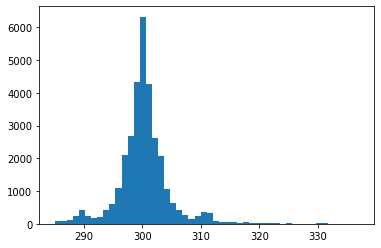

In [112]:
res = s.mask((s>s.quantile(0.99))|(s<s.quantile(0.01)))
plt.hist(res, bins=50)

In [113]:
# 3、
res = df.Radiation.rolling('6H').corr(df.Temperature)
res.tail(3)

Datetime
2016-12-31 23:45:04    0.328574
2016-12-31 23:50:03    0.261883
2016-12-31 23:55:01    0.262406
dtype: float64

In [114]:
res = df.Temperature.resample('6H', origin='03:00:00').mean()
res.head()

Datetime
2016-08-31 21:00:00    51.218750
2016-09-01 03:00:00    50.033333
2016-09-01 09:00:00    59.379310
2016-09-01 15:00:00    57.984375
2016-09-01 21:00:00    51.393939
Freq: 6H, Name: Temperature, dtype: float64

In [115]:
my_dt = df.index.shift(freq='-6H')
int_loc = [df.index.get_loc(i, method='nearest') for i in my_dt]
res = df.Radiation.iloc[int_loc]
res.tail(3)

Datetime
2016-12-31 17:45:02    9.33
2016-12-31 17:50:01    8.49
2016-12-31 17:55:02    5.84
Name: Radiation, dtype: float64

#### Ex2：水果销量数据集
现有一份2019年每日水果销量记录表：

```python
df = pd.read_csv('../data/fruit.csv')
df.head(3)
```

1、 统计如下指标：
* 每月上半月（15号及之前）与下半月葡萄销量的比值
* 每月最后一天的生梨销量总和
* 每月最后一天工作日的生梨销量总和
* 每月最后五天的苹果销量均值

2、 按月计算周一至周日各品种水果的平均记录条数，行索引外层为水果名称，内层为月份，列索引为星期。

3、 按天计算向前10个工作日窗口的苹果销量均值序列，非工作日的值用上一个工作日的结果填充。

In [118]:
df = pd.read_csv('data/fruit.csv')
df.head()

,Date,Fruit,Sale
0,2019-04-18,Peach,15
1,2019-12-29,Peach,15
2,2019-06-05,Peach,19
3,2019-10-28,Pear,19
4,2019-06-11,Peach,5


In [119]:
# 1、
df.Date = pd.to_datetime(df.Date)
df_grape = df.query("Fruit == 'Grape'")
res = df_grape.groupby([np.where(df_grape.Date.dt.day<=15,
    'First', 'Second'),df_grape.Date.dt.month]
    )['Sale'].mean().to_frame().unstack(0
    ).droplevel(0,axis=1)
res = (res.First/res.Second).rename_axis('Month')
res.head()

Month
1    1.174998
2    0.968890
3    0.951351
4    1.020797
5    0.931061
dtype: float64

In [120]:
df[df.Date.dt.is_month_end].query("Fruit == 'Pear'"
    ).groupby('Date').Sale.sum().head()

Date
2019-01-31    847
2019-02-28    774
2019-03-31    761
2019-04-30    648
2019-05-31    616
Name: Sale, dtype: int64

In [121]:
df[df.Date.isin(pd.date_range('20190101', '20191231',
    freq='BM'))].query("Fruit == 'Pear'"
    ).groupby('Date').Sale.mean().head()

Date
2019-01-31    60.500000
2019-02-28    59.538462
2019-03-29    56.666667
2019-04-30    64.800000
2019-05-31    61.600000
Name: Sale, dtype: float64

In [123]:
target_dt = df.drop_duplicates().groupby(df.Date.drop_duplicates(
    ).dt.month)['Date'].nlargest(5).reset_index(drop=True)
res = df.set_index('Date').loc[target_dt].reset_index(
    ).query("Fruit == 'Apple'")
res = res.groupby(res.Date.dt.month)['Sale'].mean(
    ).rename_axis('Month')
res.head()

Month
1    65.313725
2    54.061538
3    59.325581
4    65.795455
5    57.465116
Name: Sale, dtype: float64

In [124]:
# 2、
month_order = ['January','February','March','April',
    'May','June','July','August','September',
    'October','November','December']

week_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sum']
group1 = df.Date.dt.month_name().astype('category').cat.reorder_categories(
    month_order, ordered=True)
group2 = df.Fruit
group3 = df.Date.dt.dayofweek.replace(dict(zip(range(7),week_order))
    ).astype('category').cat.reorder_categories(
    week_order, ordered=True)

res = df.groupby([group1, group2,group3])['Sale'].count().to_frame(
    ).unstack(0).droplevel(0,axis=1)

In [125]:
res.head()

Date        January  February  March  ...  October  November  December
Fruit Date                            ...                             
Apple Mon        46        43     43  ...       42        39        45
      Tue        50        40     44  ...       57        47        47
      Wed        50        47     37  ...       46        47        38
      Thu        45        35     31  ...       63        37        40
      Fri        32        33     52  ...       37        46        41

[5 rows x 12 columns]

In [126]:
#3、
df_apple = df[(df.Fruit=='Apple')&(
    ~df.Date.dt.dayofweek.isin([5,6]))]

s = pd.Series(df_apple.Sale.values,
    index=df_apple.Date).groupby('Date').sum()
res = s.rolling('10D').mean().reindex(
    pd.date_range('20190101','20191231')).fillna(method='ffill')
res.head()

2019-01-01    189.000000
2019-01-02    335.500000
2019-01-03    520.333333
2019-01-04    527.750000
2019-01-05    527.750000
Freq: D, dtype: float64